本记录是对使用的朴素贝叶斯方法的调参记录，主要内容是对K值的更换测试

由于本人能力有限，参与的项目相对较少，调出的结果想必不是最好的，还希望各位多加指教

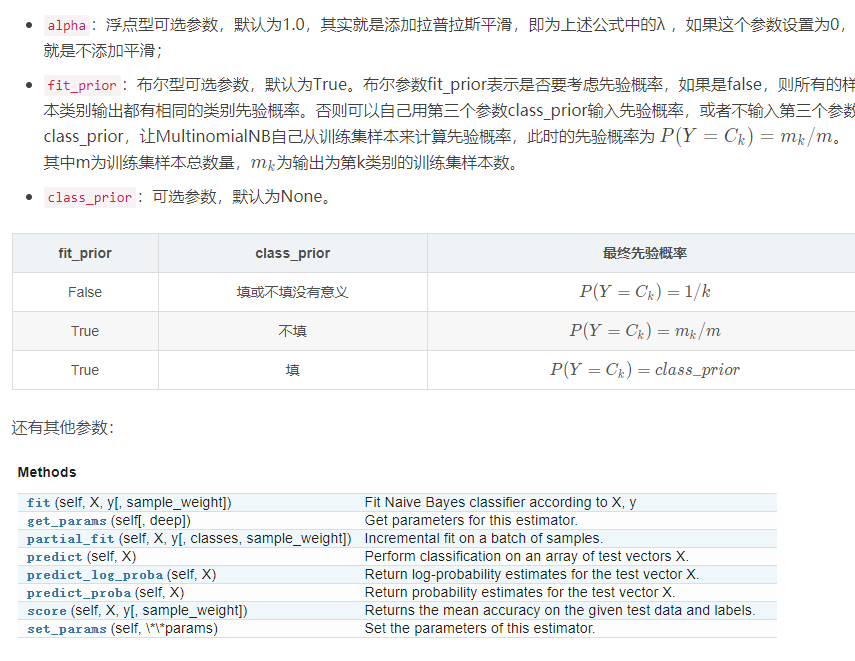

主要调参对象为alpha即平滑，发现拉普拉斯平滑的效果并不好

fit_prior以及class_prior两个参数基本上不需要，我们不需要手动输入先验概率，交给MultinomialNB自己训练就好

朴素贝叶斯的两个假设在文本分类中实际上是存在问题的。其一是其独立性，即一个特征或者单词出现的可能性与它和其他单词相邻没有关系。这在文本中是不大可能的，最极端的情况是英文中冠词和名词，动词等的搭配，几乎无法避免会产生联系，尽管在分词时只提取了词干，避免了一定的相关性，但是仍无法彻底解决这一问题。

其二是每个特征同等重要。这个假设也有问题。 如果要判断是否为垃圾短信，那么可能不需要看完所有数千个单词，而只需要看100～200个特征就足以做出判断了。尽管上述假设存在一些小的瑕疵，但朴素贝叶斯的实际效果却很好。

In [1]:
# coding=utf-8
import pandas as pd 
import numpy as np 
from pandas import Series,DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
import graphviz # doctest: +SKIP
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
import snowballstemmer
from nltk import SnowballStemmer

sms_data = pd.read_csv("E:/finalpaper/smm.csv",encoding = 'latin-1')

#设置字体并显示中文
plt.rcParams['font.family'] = 'SimHei'

sms_data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
sms = sms_data.rename(columns = {'v1':'label','v2':'message'})

#去掉所有重复行
sms = sms.drop_duplicates()
sms.to_csv("E:/finalpaper/smm_drop.csv",encoding = 'latin-1',index = False)

#添加长度特征
sms['length'] = sms['message'].apply(len)
text_feat = sms['message'].copy()

def stemmer(text):
    text = text.split()
    words = ""
    for i in text:
        stemmer = SnowballStemmer("english")
        words += (stemmer.stem(i))+" "
    return words
text_feat = text_feat.apply(stemmer)

vectorizer = TfidfVectorizer("english")
features = vectorizer.fit_transform(text_feat)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_curve, auc

C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Naive Bayesian
0
Naive Bayesian
1
Naive Bayesian
2
Naive Bayesian
3
Naive Bayesian
4
Naive Bayesian
5
Naive Bayesian
6
Naive Bayesian
7
Naive Bayesian
8
Naive Bayesian
9


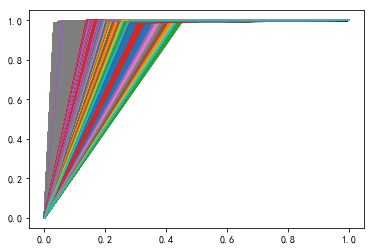

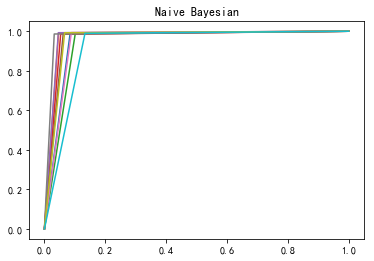

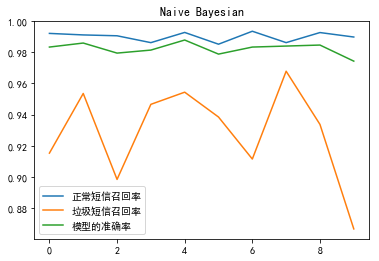

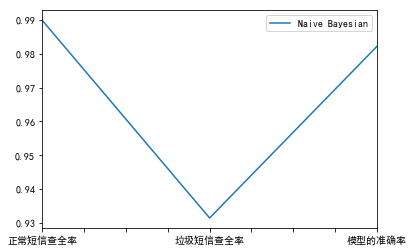

In [11]:
mnb = MultinomialNB(alpha = 0.018)
clfs = {'Naive Bayesian':mnb}
a = []
figure_count = 0
key = 'Naive Bayesian'
model = clfs[key]
score = []
hrecall = []
precall = []
b = []

plt.figure(figure_count)

for i in range(10):
    print(key)
    print(i)
    features_train,features_test,labels_train,labels_test = train_test_split(features,sms['label'],test_size = 0.3,random_state = 111 + i)
    model.fit(features_train,labels_train)
    score.append(sum(model.predict(features_test) == labels_test)*1.0/len(labels_test))
    cmat = confusion_matrix(model.predict(features_test),labels_test)
    fpr,tpr,thresholds = roc_curve(pd.DataFrame(labels_test).replace(('ham','spam'),(1,0)),pd.DataFrame(model.predict(features_test)).replace(('ham','spam'),(1,0)),pos_label = 1)
    hrecall.append(cmat[0,0]*1.0/(cmat[0,0] + cmat[1,0]))
    precall.append(cmat[1,1]*1.0/(cmat[0,1] + cmat[1,1]))
    recall = pd.DataFrame([hrecall,precall,score],index = [u'正常短信召回率',u'垃圾短信召回率',u'模型的准确率']).T

    plt.plot(fpr,tpr)

b.append(np.mean(recall.iloc[:,0]))
b.append((np.sum(recall.iloc[:,1]) - np.min(recall.iloc[:,1]) - np.max(recall.iloc[:,1]))/8)
b.append(np.mean(recall.iloc[:,2]))
a.append((key,b))

plt.title(key)
plt.show()
figure_count = figure_count + 1

plt.figure(figure_count)
plt.plot(recall.iloc[:,0])
plt.plot(recall.iloc[:,1])
plt.plot(recall.iloc[:,2])
plt.title(key)
plt.legend()
plt.show()

figure_count = figure_count + 1
    
data = pd.DataFrame(dict(a),index = [u'正常短信查全率',u'垃圾短信查全率',u'模型的准确率'])
data.plot()
plt.show()

In [9]:
alpha_store = []
for alpha_count in range(500):
    alpha_count = alpha_count/1000
    mnb = MultinomialNB(alpha = alpha_count)
    clfs = {'Naive Bayesian':mnb}
    a = []
    key = 'Naive Bayesian'
    model = clfs[key]
    score = []
    hrecall = []
    precall = []
    b = []
    
    for i in range(10):
        features_train,features_test,labels_train,labels_test = train_test_split(features,sms['label'],test_size = 0.3,random_state = 111 + i)
        model.fit(features_train,labels_train)
        score.append(sum(model.predict(features_test) == labels_test)*1.0/len(labels_test))
        cmat = confusion_matrix(model.predict(features_test),labels_test)
        fpr,tpr,thresholds = roc_curve(pd.DataFrame(labels_test).replace(('ham','spam'),(1,0)),pd.DataFrame(model.predict(features_test)).replace(('ham','spam'),(1,0)),pos_label = 1)
        hrecall.append(cmat[0,0]*1.0/(cmat[0,0] + cmat[1,0]))
        precall.append(cmat[1,1]*1.0/(cmat[0,1] + cmat[1,1]))
        recall = pd.DataFrame([hrecall,precall,score],index = [u'正常短信召回率',u'垃圾短信召回率',u'模型的准确率']).T

        plt.plot(fpr,tpr)
    print("垃圾短信查全率")
    print((np.sum(recall.iloc[:,1]) - np.min(recall.iloc[:,1]) - np.max(recall.iloc[:,1]))/8)
    print("n_neighbors_count：")
    print(alpha_count)
    alpha_store.append((np.sum(recall.iloc[:,1]) - np.min(recall.iloc[:,1]) - np.max(recall.iloc[:,1]))/8)
    print('\n')

C:\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


垃圾短信查全率
0.8800605920627195
n_neighbors_count：
0.0


垃圾短信查全率
0.9150078163275897
n_neighbors_count：
0.001


垃圾短信查全率
0.9189654177700467
n_neighbors_count：
0.002


垃圾短信查全率
0.920784769659767
n_neighbors_count：
0.003


垃圾短信查全率
0.9227149687481251
n_neighbors_count：
0.004


垃圾短信查全率
0.923941903576234
n_neighbors_count：
0.005


垃圾短信查全率
0.9259888507212626
n_neighbors_count：
0.006


垃圾短信查全率
0.9259888507212626
n_neighbors_count：
0.007


垃圾短信查全率
0.9266608937320153
n_neighbors_count：
0.008


垃圾短信查全率
0.9266608937320153
n_neighbors_count：
0.009


垃圾短信查全率
0.928235819549031
n_neighbors_count：
0.01


垃圾短信查全率
0.928235819549031
n_neighbors_count：
0.011


垃圾短信查全率
0.9288282366106424
n_neighbors_count：
0.012


垃圾短信查全率
0.9294966858085034
n_neighbors_count：
0.013


垃圾短信查全率
0.9294966858085034
n_neighbors_count：
0.014


垃圾短信查全率
0.9301651350063643
n_neighbors_count：
0.015


垃圾短信查全率
0.9307996527728618
n_neighbors_count：
0.016


垃圾短信查全率
0.9314341705393593
n_neighbors_count：
0.017


垃圾短信查全率
0.9314341705393593
n_neighb

垃圾短信查全率
0.9036134367449222
n_neighbors_count：
0.153


垃圾短信查全率
0.9036134367449222
n_neighbors_count：
0.154


垃圾短信查全率
0.9036134367449222
n_neighbors_count：
0.155


垃圾短信查全率
0.9024286026216994
n_neighbors_count：
0.156


垃圾短信查全率
0.9024286026216994
n_neighbors_count：
0.157


垃圾短信查全率
0.9024286026216994
n_neighbors_count：
0.158


垃圾短信查全率
0.9024286026216994
n_neighbors_count：
0.159


垃圾短信查全率
0.9024286026216994
n_neighbors_count：
0.16


垃圾短信查全率
0.9012658119240251
n_neighbors_count：
0.161


垃圾短信查全率
0.9012658119240251
n_neighbors_count：
0.162


垃圾短信查全率
0.9012658119240251
n_neighbors_count：
0.163


垃圾短信查全率
0.9012658119240251
n_neighbors_count：
0.164


垃圾短信查全率
0.9012658119240251
n_neighbors_count：
0.165


垃圾短信查全率
0.9006844165751879
n_neighbors_count：
0.166


垃圾短信查全率
0.9006844165751879
n_neighbors_count：
0.167


垃圾短信查全率
0.9006844165751879
n_neighbors_count：
0.168


垃圾短信查全率
0.9006844165751879
n_neighbors_count：
0.169


垃圾短信查全率
0.9006844165751879
n_neighbors_count：
0.17


垃圾短信查全率
0.9006844165751879
n_n

垃圾短信查全率
0.8520250774757863
n_neighbors_count：
0.306


垃圾短信查全率
0.8520250774757863
n_neighbors_count：
0.307


垃圾短信查全率
0.851443682126949
n_neighbors_count：
0.308


垃圾短信查全率
0.8502588480037262
n_neighbors_count：
0.309


垃圾短信查全率
0.8502588480037262
n_neighbors_count：
0.31


垃圾短信查全率
0.8495903988058654
n_neighbors_count：
0.311


垃圾短信查全率
0.8495903988058654
n_neighbors_count：
0.312


垃圾短信查全率
0.8477371154847816
n_neighbors_count：
0.313


垃圾短信查全率
0.8471446984231702
n_neighbors_count：
0.314


垃圾短信查全率
0.8471446984231702
n_neighbors_count：
0.315


垃圾短信查全率
0.8471446984231702
n_neighbors_count：
0.316


垃圾短信查全率
0.846552281361559
n_neighbors_count：
0.317


垃圾短信查全率
0.8459708860127219
n_neighbors_count：
0.318


垃圾短信查全率
0.8452646713234563
n_neighbors_count：
0.319


垃圾短信查全率
0.8440212125951781
n_neighbors_count：
0.32


垃圾短信查全率
0.8440212125951781
n_neighbors_count：
0.321


垃圾短信查全率
0.8433527633973171
n_neighbors_count：
0.322


垃圾短信查全率
0.8433527633973171
n_neighbors_count：
0.323


垃圾短信查全率
0.8433527633973171
n_nei

垃圾短信查全率
0.7899924153383691
n_neighbors_count：
0.459


垃圾短信查全率
0.7893203723276163
n_neighbors_count：
0.46


垃圾短信查全率
0.7893203723276163
n_neighbors_count：
0.461


垃圾短信查全率
0.7887279552660049
n_neighbors_count：
0.462


垃圾短信查全率
0.7881355382043937
n_neighbors_count：
0.463


垃圾短信查全率
0.7879183770436673
n_neighbors_count：
0.464


垃圾短信查全率
0.7872838592771698
n_neighbors_count：
0.465


垃圾短信查全率
0.7872838592771698
n_neighbors_count：
0.466


垃圾短信查全率
0.7866493415106723
n_neighbors_count：
0.467


垃圾短信查全率
0.786056924449061
n_neighbors_count：
0.468


垃圾短信查全率
0.7860569244490608
n_neighbors_count：
0.469


垃圾短信查全率
0.7854645073874494
n_neighbors_count：
0.47


垃圾短信查全率
0.7854645073874494
n_neighbors_count：
0.471


垃圾短信查全率
0.7854645073874494
n_neighbors_count：
0.472


垃圾短信查全率
0.7849126083061386
n_neighbors_count：
0.473


垃圾短信查全率
0.7849126083061386
n_neighbors_count：
0.474


垃圾短信查全率
0.784206393616873
n_neighbors_count：
0.475


垃圾短信查全率
0.784206393616873
n_neighbors_count：
0.476


垃圾短信查全率
0.7835343506061203
n_neig

In [10]:
max(alpha_store)

0.9314341705393593